# Load the environment

In [165]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
# Common imports
import fitsio
import numpy as np
import os
import pandas as pd
import sys

In [167]:
# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=18)

In [168]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [169]:
# QuasarNET imports
from quasarnet.models import QuasarNET, custom_loss
from quasarnet.io import read_truth, read_data, objective, wave
from quasarnet.utils import process_preds, absorber_IGM

In [170]:
# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.compat.v1.reset_default_graph
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [171]:
import fnmatch
from scipy.interpolate import splev, splrep

In [172]:
def plot_spectrum(ival,X,c_line,z_line,zbest,Y,z,c_th=0.5,ndetect=1):
    llmin = np.log10(3600)
    llmax = np.log10(10000)
    dll = 1e-3

    nbins = int((llmax-llmin)/dll)
    wave = 10**(llmin + np.arange(nbins)*dll)
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.plot(wave, X[ival,:])
    
    isqso_truth = (Y[ival,:].argmax()==2) | (Y[ival,:].argmax()==3)
    isqso_qn = (c_line[:,ival].sum()>c_th)>=ndetect
    
    title = r'Is QSO? VI: {}, QN: {}'.format(isqso_truth,isqso_qn)
    title += '\n'
    title += r'$z_{{VI}}$={:1.3f}, $z_{{QN}}$='.format(z[ival])
    if isqso_qn:
        title += r'{:1.3f}'.format(zbest[ival])
    else:
        title += 'N/A'
    
    ax.set_title(title)
    m = X[ival,:].min()
    M = X[ival,:].max()
    ax.grid()
    ax.set_ylim(m-2,M+2)
    for il,l in enumerate(lines):
        lam = absorber_IGM[l]*(1+z_line[il,ival])
        w = abs(wave-lam)<100
        if w.sum()>0:
            m = X[ival,w].min()-1
            M = X[ival,w].max()+1
            ax.plot([lam,lam], [m,M],'r--', alpha=0.1+0.9*c_line[il,ival])
            ax.text(lam,M+0.5,'c$_{{{}}}={}$'.format(l,round(c_line[il,ival],3)),
                     horizontalalignment='center',alpha=0.1+0.9*c_line[il,ival])
    ax.set_xlabel(r'$\lambda_\mathrm{obs}~[\AA]$')
    ax.set_ylabel(r'renormalised flux')
    plt.show()
    
    return

In [173]:
def get_calum_data(calum_dir):
    file_matching = fitsio.FITS(calum_dir,vstorage='object')
    compare_information = pd.DataFrame({
    'tileID_desi': file_matching[1]['TILEID'][:].byteswap().newbyteorder(),
    'NIGHT_desi': file_matching[1]['NIGHT'][:].byteswap().newbyteorder(),    
    'thingid_desi': file_matching[1]['TARGETID'][:].byteswap().newbyteorder(),
    'mjd_desi':file_matching[1]['MJD'][:].byteswap().newbyteorder(),
    'fib_desi':file_matching[1]['FIBER'][:].byteswap().newbyteorder(),
    'z_desi':file_matching[1]['Z'][:].byteswap().newbyteorder()})
    return compare_information

# Train on DR12 data and Test on DESI data:

## Train the QuasarNET model with DR12 data, with good classification labels:

In [174]:
lines = ['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
lines_bal = ['CIV(1548)']
loss = [custom_loss]*(len(lines)+len(lines_bal))
nspec = 30000
truth_file=(['/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/truth_DR12Q.fits'])
truth = read_truth(truth_file)
tids_full,X_full,Y_full,z_full,bal_full = read_data(['/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits'], truth, nspec=nspec)

# Load the training data.
data_file = '/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_train_0.fits'
h = fitsio.FITS(data_file)
tids_train = h[1]['TARGETID'][:]
w = np.in1d(tids_full, tids_train)
X_train = X_full[w]
Y_train = Y_full[w]
z_train = z_full[w]
bal_train = bal_full[w]

# To get the validation data, remove the spectra in the training sample from the full sample
w = ~np.in1d(tids_full, tids_train)
tids_val = tids_full[w]
X_val = X_full[w]
Y_val = Y_full[w]
z_val = z_full[w]
bal_val = bal_full[w]
ntrain = 10000
nepochs = 5
model = QuasarNET((X_train.shape[1],1), nlines=len(lines)+len(lines_bal))
model.compile(optimizer=Adam(), loss=loss, metrics=[])

target, sample_weight = objective(z_train[:ntrain],Y_train[:ntrain],bal_train[:ntrain],lines=lines,lines_bal=lines_bal)
loss_history = model.fit(X_train[:ntrain,:,None], target, epochs=nepochs, batch_size=32, sample_weight=sample_weight)

INFO: reading data from /global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits
INFO: removing 82 spectra missing in truth
INFO: found (29786,) spectra in file /global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits
INFO: removing 40 spectra with zero weights
INFO: removing 0 spectra with zero flux
Epoch 1/5
313/313 [==============================] - 9s 28ms/step - loss: 1.2223 - conc_box_0_loss: 0.1803 - conc_box_1_loss: 0.2057 - conc_box_2_loss: 0.2307 - conc_box_3_loss: 0.2148 - conc_box_4_loss: 0.1404 - conc_box_5_loss: 0.0931 - conc_box_6_loss: 0.1573
Epoch 2/5
313/313 [==============================] - 8s 27ms/step - loss: 0.2619 - conc_box_0_loss: 0.0372 - conc_box_1_loss: 0.0472 - conc_box_2_loss: 0.0560 - conc_box_3_loss: 0.0544 - conc_box_4_loss: 0.0221 - conc_box_5_loss: 0.0092 - conc_box_6_loss: 0.0359
Epoch 3/5
313/313 [==============================] - 9s 27ms/step - loss: 0.1518 - conc_box_0_loss: 0.0234 - conc_box_1_loss: 0.

## Get DESI SV data of tile 68002, and do the test:

In [175]:
data_desi = {'tileID_desi':[], 'NIGHT_desi': [], 'thingid_desi': [], 'mjd_desi': [], 'fib_desi':[], 'z_desi':[], 'flux':[], 'wavelength':[], 'ivar':[], 'flux_post':[], 'classification':[]}
date = []
fail_expoture = 0
release= 'daily'
dir_desi = '/global/cfs/cdirs/desi/spectro/redux/'+release+'/tiles'
dir_total='/global/cfs/cdirs/desi/spectro/redux/daily/tiles/68002/20200315'
file_total = []
file_cframe = []
for file in os.listdir(dir_total):
    if fnmatch.fnmatch(file, 'coadd*.fits'):
        file_total.append(dir_total+'/'+file)
    if fnmatch.fnmatch(file, 'cframe-b*.fits'):
        file_cframe.append(dir_total+'/'+file)
DESI_quasar = fitsio.FITS('/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_andes_68002_20200315.fits',vstorage='object')
targetid = DESI_quasar[1]['TARGETID'][:]

llmin = np.log10(3600)
llmax = np.log10(10000)
dll = 1e-3
nbins = int((llmax-llmin)/dll)
wave_post = 10**(llmin + np.arange(nbins)*dll)

for coadd_file in file_total:
    for TARGETID in targetid:
        file = fitsio.FITS(coadd_file,vstorage='object')
        #print(file,file[1])
        place = np.where(file['FIBERMAP']['TARGETID'][:]==TARGETID)
        if place[0].any():
            order = int(place[0][0])
            #if desi_catalogue.z_desi[i] > 2.1:
            try:
                wavelength = file['BRZ_WAVELENGTH'][:]
                flux = file['BRZ_FLUX'][order,:][0]
                ivar = file['BRZ_IVAR'][order,:][0]
            except:
                wavelength = np.hstack((file['B_WAVELENGTH'][:], file['R_WAVELENGTH'][:],file['Z_WAVELENGTH'][:]))
                flux = np.hstack((file['B_FLUX'][order,:][0],file['R_FLUX'][order,:][0],file['Z_FLUX'][order,:][0]))
                ivar = np.hstack((file['B_IVAR'][order,:][0],file['R_IVAR'][order,:][0],file['Z_IVAR'][order,:][0]))
            func_flux = splrep(wavelength,flux)
            flux_post = splev(wave_post,func_flux)
            flux_post[434:443]=0
            if flux_post[0].any():
                data_desi['wavelength'].append(np.transpose(wavelength.tolist()))
                data_desi['flux'].append(np.transpose(flux.tolist()))
                data_desi['ivar'].append(np.transpose(ivar.tolist()))
                data_desi['flux_post'].append(np.transpose(flux_post.tolist()))
                data_desi['thingid_desi'].append(file[1]['TARGETID'][order])
                #data_desi['mjd_desi'].append(desi_catalogue.mjd_desi[i])
                #data_desi['fib_desi'].append(desi_catalogue.fib_desi[i])
                file_redshift = str.replace(coadd_file, 'coadd', 'zbest')
                file_redshift = fitsio.FITS(file_redshift,vstorage='object')
                data_desi['z_desi'].append(file_redshift[1]['Z'][:][order])
                if file_redshift[1]['SPECTYPE'][:][order] == 'QSO':
                    if file_redshift[1]['Z'][:][order] < 2.1:
                        data_desi['classification'].append([0,0,1,0,0])
                    if file_redshift[1]['Z'][:][order] > 2.1:
                        data_desi['classification'].append([0,0,0,1,0])
print('{} targets found'.format(len(data_desi['flux'])))


1101 targets found


### Save and load data:

In [176]:
from astropy.io import fits
from astropy.io.fits import Column
len_data = len(data_desi['thingid_desi'])
a1 = Column(name='THING_ID', format='1K', array=data_desi['thingid_desi'])
a2 = Column(name='Z_VI', format='1D', array=data_desi['z_desi'])
a3 = Column(name='MJD', format='1D', array=data_desi['mjd_desi'])
a4 = Column(name='FIBERID', format='1K', array=data_desi['fib_desi'])
a5 = Column(name='tileID', format='1K', array=data_desi['tileID_desi'])
a6 = Column(name='NIGHT', format='1K', array=data_desi['NIGHT_desi'])
a7 = Column(name='classification', format='5K', array=data_desi['classification'])
data = np.array(data_desi['flux_post']).reshape(len(data_desi['flux_post']),-1)
hdr = fits.Header()
primary_hdu = fits.PrimaryHDU(data,header=hdr)
hdu = fits.BinTableHDU.from_columns([a1, a2, a3, a4, a5, a6, a7])
thdulist = fits.HDUList([primary_hdu,hdu])
thdulist.writeto('/global/homes/t/tanting/Machine_Learning_quasar/QuasarNET/desi_catalogue.fits',overwrite=True)

In [177]:
desi_quasar_data = fitsio.FITS('/global/homes/t/tanting/Machine_Learning_quasar/QuasarNET/desi_catalogue.fits',vstorage='object')
X_desi = desi_quasar_data[0][:,:]
Y_desi = desi_quasar_data[1]['classification'][:]
z_desi = desi_quasar_data[1]['Z_VI'][:]

### Do the test:

INFO: nspec = 1101, nboxes=13


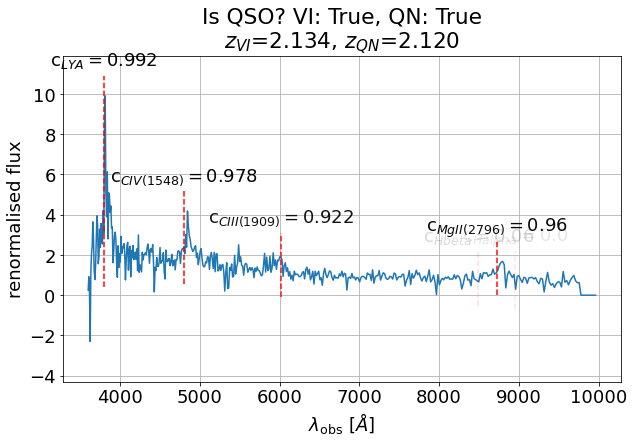

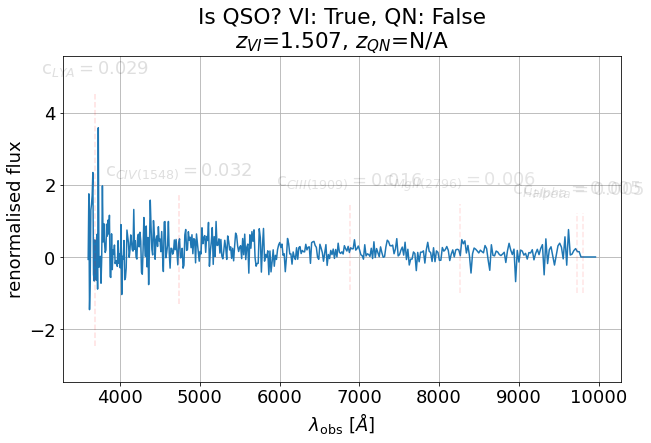

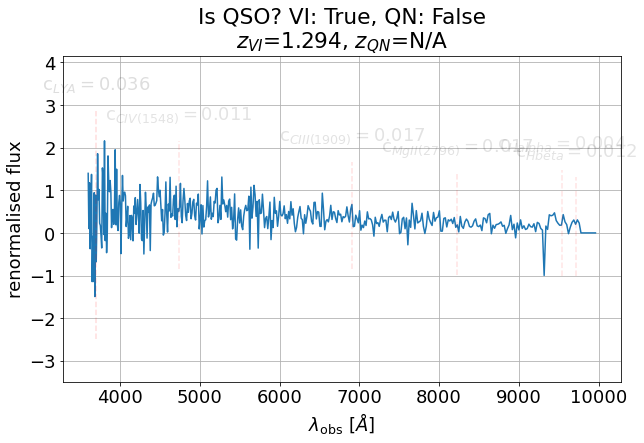

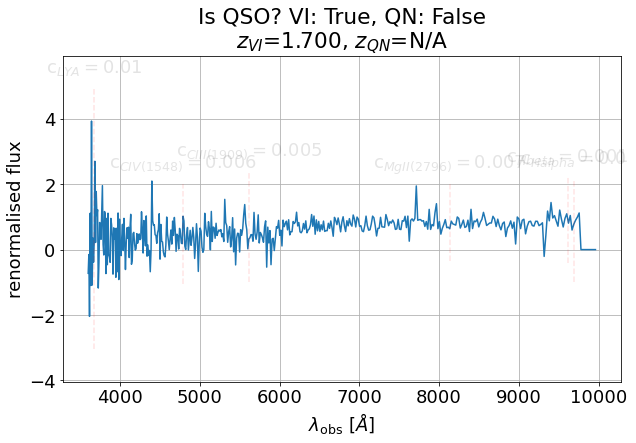

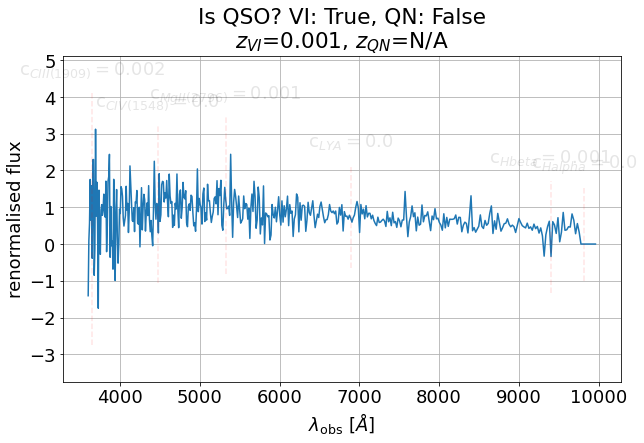

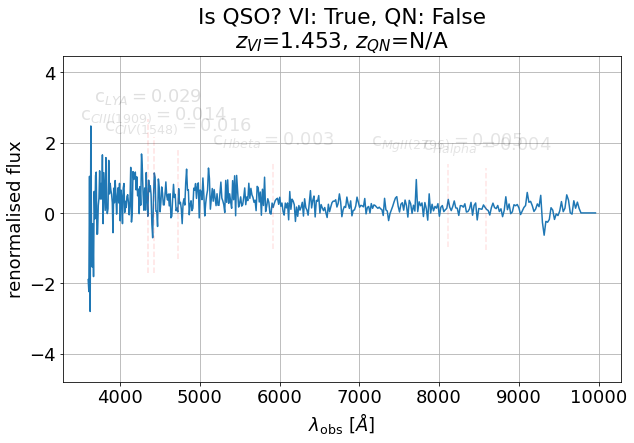

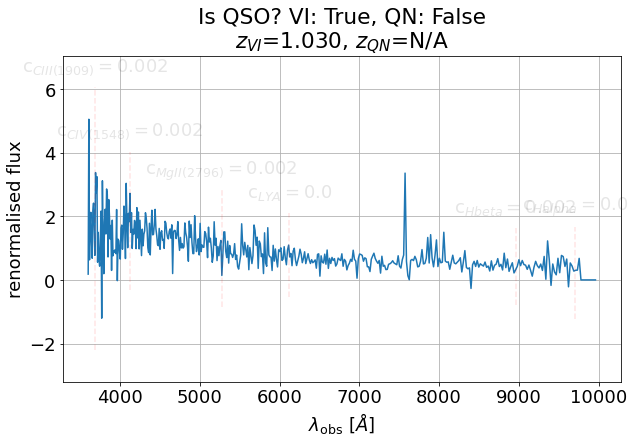

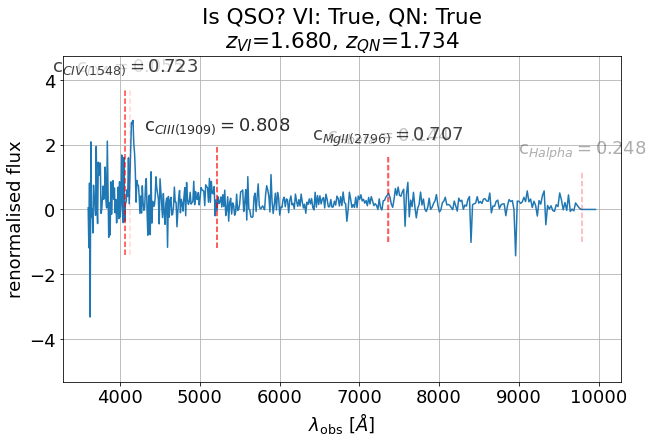

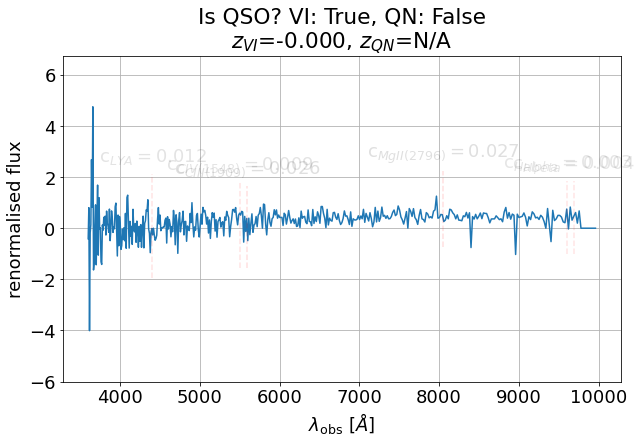

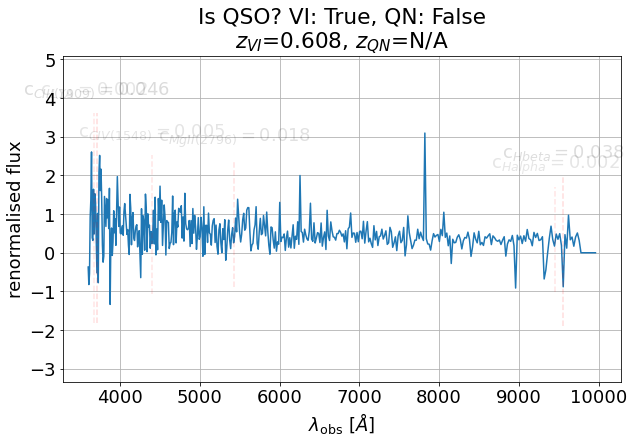

In [178]:
p = model.predict(X_desi[:,:,None])
c_line, z_line, zbest, c_line_bal, z_line_bal = process_preds(p, lines, lines_bal)

ndetect = 1
c_th = 0.5
for num in range(10):
    plot_spectrum(num,X_desi,c_line,z_line,zbest,Y_desi,z_desi,c_th=c_th,ndetect=ndetect)

In [193]:
zgood = (z_desi>0) & (abs(zbest-z_desi) < dv_max*(1+z_desi))
zgood

array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False,  True,
       False, False, False,  True, False,  True,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False,  True, False,  True, False, False, False,
       False,  True, False, False, False, False,  True, False,  True,
        True, False, False, False, False, False, False, False, False,
        True, False, False,  True])

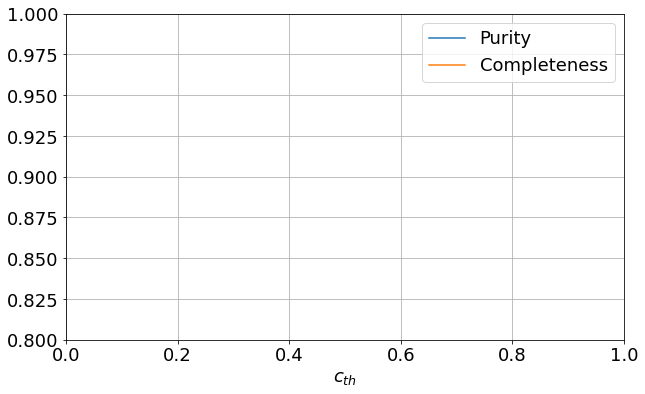

In [189]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

ndetect = 1

# Set up our arrays.
c_th = np.arange(0,1,0.01)
pur = c_th*0
com = c_th*0
dv_max = 6000./300000.

# Determine which objects are true QSOs, and which are "bad"
isqso_truth = (Y_desi.argmax(axis=1)==2) | (Y_desi.argmax(axis=1)==3)
is_bad = Y_desi.argmax(axis=1)==4

# Determine which spectra QN accurately estimated the redshift for
zgood = (z_desi>0) & (abs(zbest-z_desi) < dv_max*(1+z_desi))

# For each value of confidence threshold, compute purity and completeness.
for i,cth in enumerate(c_th):
    isqso_qn = (c_line>cth).sum(axis=0)>=ndetect
    ntrue_positives = (isqso_qn & zgood & ~is_bad).sum()
    pur[i] = ntrue_positives/(isqso_qn & (~is_bad)).sum()
    com[i] = (isqso_qn & zgood & isqso_truth).sum()/isqso_truth.sum()
    
# Plot them!
ax.plot(c_th, pur, label='Purity')
ax.plot(c_th, com, label='Completeness')
#ax.set_xlim(0.0,1.0)
#ax.set_ylim(0.8,1.0)
ax.set_xlabel(r'$c_{th}$')
ax.grid()
ax.legend()

# Test on good QSO targets on whole daily release

## Get and save the data

In [223]:
desi_catalogue = get_calum_data('/global/u1/t/tanting/DESI_analysis/DESI_eboss_match/DESI_eboss_match_quasar.fits')[0:200]
data_desi = {'tileID_desi':[], 'NIGHT_desi': [], 'thingid_desi': [], 'mjd_desi': [], 'fib_desi':[], 'z_desi':[], 'flux':[], 'wavelength':[], 'ivar':[], 'flux_post':[], 'classification':[]}
release= 'daily'
dir_desi = '/global/cfs/cdirs/desi/spectro/redux/'+release+'/tiles'

llmin = np.log10(3600)
llmax = np.log10(10000)
dll = 1e-3
nbins = int((llmax-llmin)/dll)
wave_post = 10**(llmin + np.arange(nbins)*dll)

for i,dir_tile,dir_night in zip(desi_catalogue.index,desi_catalogue.tileID_desi,desi_catalogue.NIGHT_desi):
    dir_total=dir_desi+'/'+str(dir_tile)+'/'+str(dir_night)
    file_total = []
    file_cframe = []
    try:
        for file in os.listdir(dir_total):
            if fnmatch.fnmatch(file, 'coadd*.fits'):
                file_total.append(dir_total+'/'+file)
            if fnmatch.fnmatch(file, 'cframe-b*.fits'):
                file_cframe.append(dir_total+'/'+file)
        for coadd_file in file_total:
            file = fitsio.FITS(coadd_file,vstorage='object')
            place = np.where(file['FIBERMAP']['TARGETID'][:]==desi_catalogue.thingid_desi[i])
            if place[0].any():
                if not desi_catalogue.thingid_desi[i] in data_desi['thingid_desi']:
                    order = int(place[0][0])
                    if desi_catalogue.fib_desi[i]==file['FIBERMAP']['FIBER'][:][order]:
                        try:
                            wavelength = file['BRZ_WAVELENGTH'][:]
                            flux = file['BRZ_FLUX'][order,:][0]
                            ivar = file['BRZ_IVAR'][order,:][0]
                        except:
                            wavelength = np.hstack((file['B_WAVELENGTH'][:], file['R_WAVELENGTH'][:],file['Z_WAVELENGTH'][:]))
                            flux = np.hstack((file['B_FLUX'][order,:][0],file['R_FLUX'][order,:][0],file['Z_FLUX'][order,:][0]))
                            ivar = np.hstack((file['B_IVAR'][order,:][0],file['R_IVAR'][order,:][0],file['Z_IVAR'][order,:][0]))
                        func_flux = splrep(wavelength,flux)
                        flux_post = splev(wave_post,func_flux)
                        #flux_post[0:2]=0
                        flux_post[434:443]=0
                        #flux_post[flux_post>150]=150
                        #flux_post[flux_post<-100]=-100
                        if flux_post[0].any() and np.max(flux)<100:
                            data_desi['wavelength'].append(np.transpose(wavelength.tolist()))
                            data_desi['flux'].append(np.transpose(flux.tolist()))
                            data_desi['ivar'].append(np.transpose(ivar.tolist()))
                            data_desi['flux_post'].append(np.transpose(flux_post.tolist()))
                            #data_desi['tileID_desi'].append(desi_catalogue.tileID_desi[i])
                            #data_desi['NIGHT_desi'].append(desi_catalogue.NIGHT_desi[i])
                            data_desi['thingid_desi'].append(file[1]['TARGETID'][order])
                            #data_desi['mjd_desi'].append(desi_catalogue.mjd_desi[i])
                            #data_desi['fib_desi'].append(desi_catalogue.fib_desi[i])
                            file_redshift = str.replace(coadd_file, 'coadd', 'zbest')
                            file_redshift = fitsio.FITS(file_redshift,vstorage='object')
                            data_desi['z_desi'].append(file_redshift[1]['Z'][:][order])
                            if file_redshift[1]['SPECTYPE'][:][order] == 'QSO':
                                if file_redshift[1]['Z'][:][order] < 2.1:
                                    data_desi['classification'].append([0,0,1,0,0])
                                if file_redshift[1]['Z'][:][order] > 2.1:
                                    data_desi['classification'].append([0,0,0,1,0])
    except:
        continue
print('finish searching for {} targets, with {} targets found'.format(desi_catalogue.index[-1]+1,len(data_desi['flux'])))


finish searching for 200 targets, with 75 targets found


In [224]:
from astropy.io import fits
from astropy.io.fits import Column
len_data = len(data_desi['thingid_desi'])
a1 = Column(name='THING_ID', format='1K', array=data_desi['thingid_desi'])
a2 = Column(name='Z_VI', format='1D', array=data_desi['z_desi'])
a3 = Column(name='MJD', format='1D', array=data_desi['mjd_desi'])
a4 = Column(name='FIBERID', format='1K', array=data_desi['fib_desi'])
a5 = Column(name='tileID', format='1K', array=data_desi['tileID_desi'])
a6 = Column(name='NIGHT', format='1K', array=data_desi['NIGHT_desi'])
a7 = Column(name='classification', format='5K', array=data_desi['classification'])
data = np.array(data_desi['flux_post']).reshape(len(data_desi['flux_post']),-1)
hdr = fits.Header()
primary_hdu = fits.PrimaryHDU(data,header=hdr)
hdu = fits.BinTableHDU.from_columns([a1, a2, a3, a4, a5, a6, a7])
thdulist = fits.HDUList([primary_hdu,hdu])
thdulist.writeto('/global/homes/t/tanting/Machine_Learning_quasar/QuasarNET/desi_catalogue.fits',overwrite=True)

desi_quasar_data = fitsio.FITS('/global/homes/t/tanting/Machine_Learning_quasar/QuasarNET/desi_catalogue.fits',vstorage='object')
X_desi = desi_quasar_data[0][:,:]
Y_desi = desi_quasar_data[1]['classification'][:]
z_desi = desi_quasar_data[1]['Z_VI'][:]

### Do the test:

INFO: nspec = 75, nboxes=13


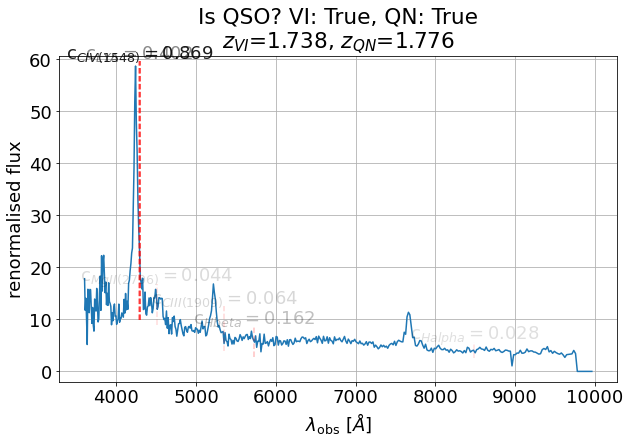

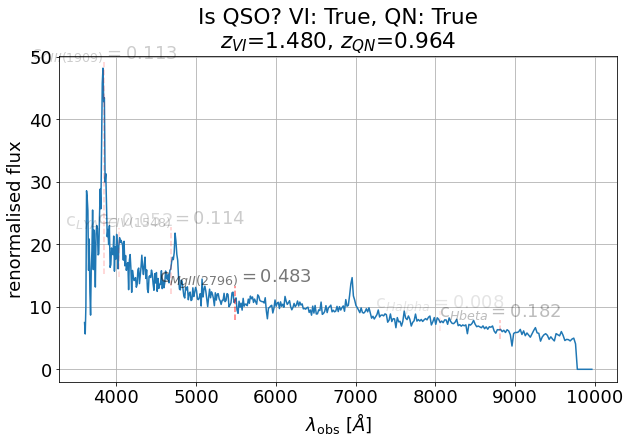

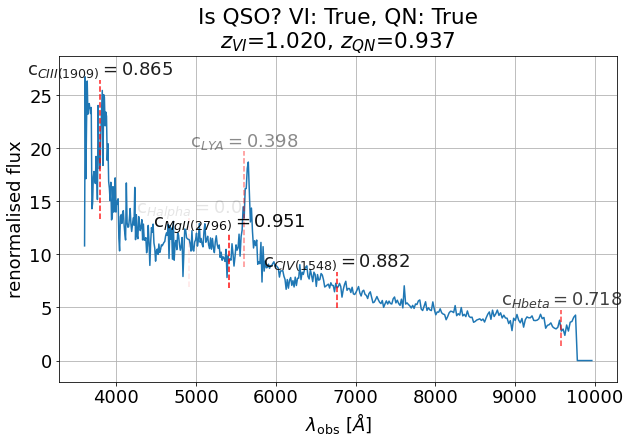

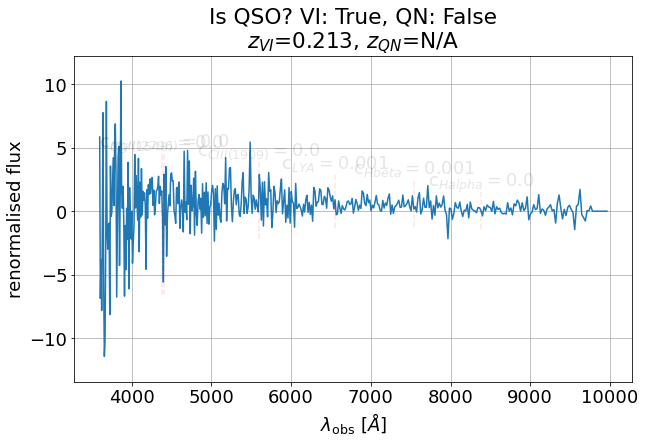

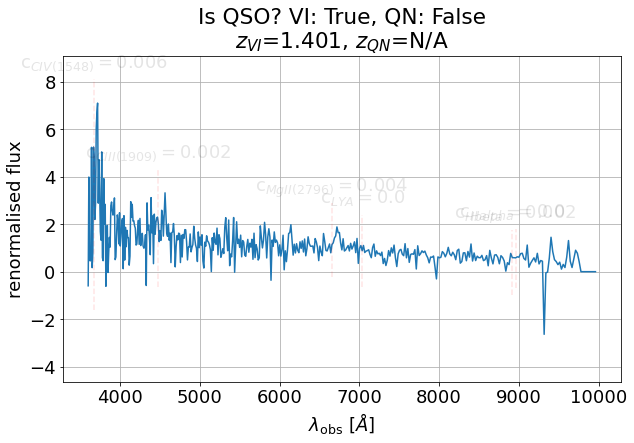

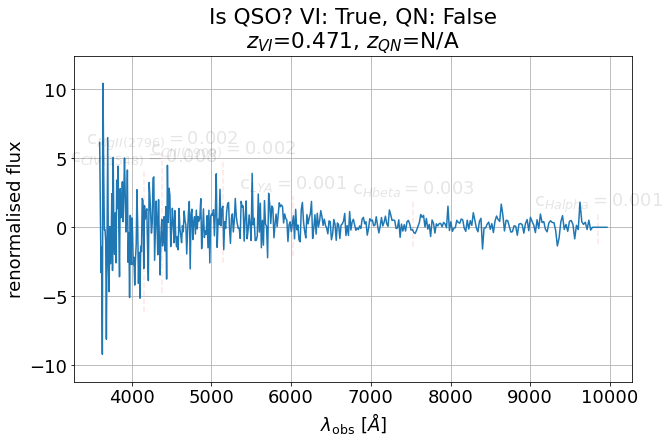

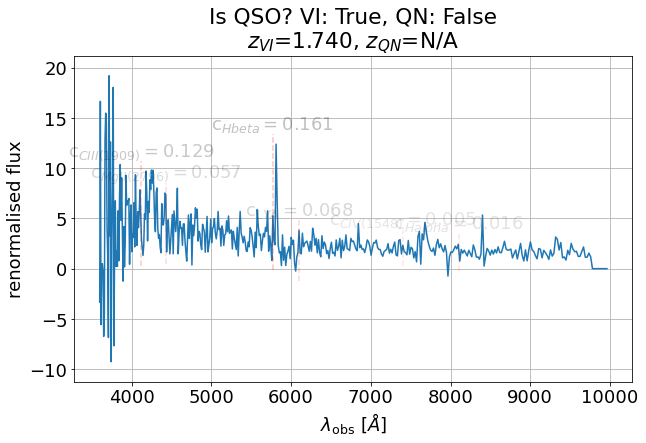

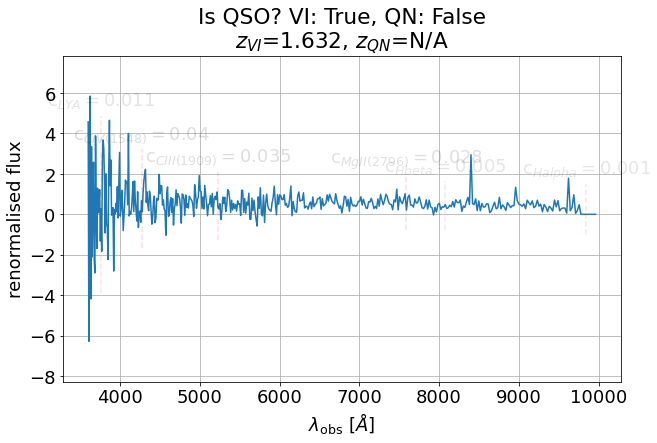

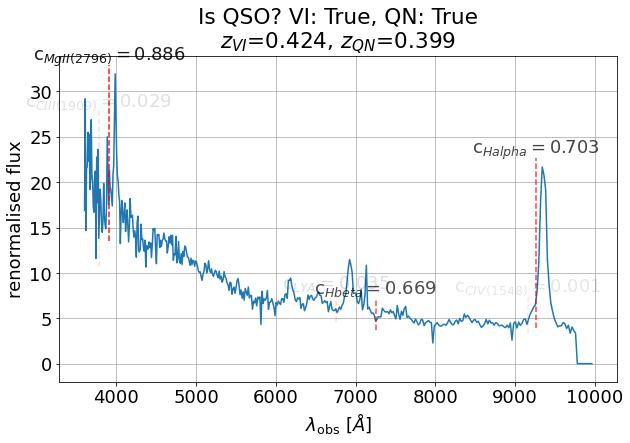

In [ ]:
p = model.predict(X_desi[:,:,None])
c_line, z_line, zbest, c_line_bal, z_line_bal = process_preds(p, lines, lines_bal)

ndetect = 1
c_th = 0.5
for num in range(10):
    plot_spectrum(num,X_desi,c_line,z_line,zbest,Y_desi,z_desi,c_th=c_th,ndetect=ndetect)

No handles with labels found to put in legend.


91918.53125
3563.414794921875
2137.2197265625
354.8683776855469
231.88587951660156
10282.732421875
2143.3466796875
177.65293884277344
317.1697998046875
2061.200439453125
1222.9368896484375
1859.5244140625
3774.443359375
744715.1875
78471.84375
1455.2164306640625
1350.5867919921875
848.0081787109375
1179.4656982421875
615.5704956054688
578.8275146484375
64995.25390625
638.2525024414062
869.611328125
3697.9697265625
965.4613037109375
202.16688537597656
2744.5615234375
4164.26220703125
5387.68115234375
557.6051025390625
3132.784423828125
2026.445556640625
787.921630859375
2689.01953125
8298.2353515625
1705.229248046875
1046.9189453125
2662.41845703125
756.2305297851562
2098.33984375
1435.90869140625
1112.87158203125
1372.373291015625
54966.453125
62.870635986328125
55.3483772277832
49.48500061035156
13.508628845214844
10.092529296875
15.76398754119873
37.019107818603516
10.412212371826172
32.69588088989258
27.842761993408203
20.95686912536621
16.806299209594727
13.573136329650879
10.93005

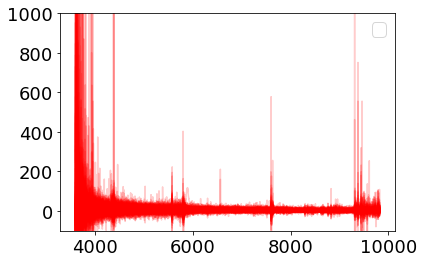

In [222]:
DESI_quasar = fitsio.FITS('/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_andes_68002_20200315.fits',vstorage='object')
plt.figure()
llmin = np.log10(3600)
llmax = np.log10(10000)
dll = 1e-3
nbins = int((llmax-llmin)/dll)
wavee = 10**(llmin + np.arange(nbins)*dll)

for i in range(120):
    print(np.max(data_desi['flux'][i]))
    flux_post = data_desi['flux_post'][i]
    #plt.plot(wavee,flux_post,color = 'blue',alpha=0.5)
    flux = data_desi['flux'][i]
    wave = data_desi['wavelength'][i]
    plt.plot(wave,flux,color = 'red',alpha=0.2)
plt.ylim(-100,1000)
plt.legend()
plt.show()

# Appendix test

No handles with labels found to put in legend.


35185923939371431
3600.0 9824.000000000688


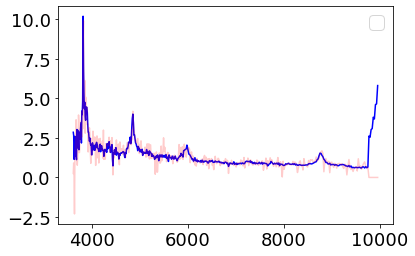

In [106]:
DESI_quasar = fitsio.FITS('/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_andes_68002_20200315.fits',vstorage='object')
plt.figure()
llmin = np.log10(3600)
llmax = np.log10(10000)
dll = 1e-3
nbins = int((llmax-llmin)/dll)
wavee = 10**(llmin + np.arange(nbins)*dll)

for i in range(len(DESI_quasar[1]['TARGETID'][:][:3])):
    place = np.where(data_desi['thingid_desi'] == DESI_quasar[1]['TARGETID'][:][i])
    if place[0].any():
        print(DESI_quasar[1]['TARGETID'][:][i])
        wave = data_desi['wavelength'][place[0][0]]
        flux = data_desi['flux'][place[0][0]]
        #wavee = np.linspace(np.min(wave),np.max(wave),len(DESI_quasar[0][i,:443][0]))
        #plt.plot(wave,flux,color = 'orange')
        plt.plot(wavee,DESI_quasar[0][i,:443][0],color = 'blue')
        
        wave = data_desi['wavelength'][place[0][0]]
        print(np.min(wave),np.max(wave))
        flux = data_desi['flux'][place[0][0]]
        ivar = data_desi['ivar'][place[0][0]]
        flux_norm = flux * np.sqrt(ivar) - np.mean(flux)
        func_flux = splrep(wave,flux)
        flux_spl = splev(wavee,func_flux)
        flux_spl[434:443]=0
        #plt.plot(wave,flux,color = 'orange')
        plt.plot(wavee,flux_spl,color = 'red',alpha=0.2)

plt.legend()
plt.show()

In [156]:
lines = ['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
loss = [custom_loss]*(len(lines))

In [256]:
import pandas as pd
truth=pd.read_csv('/global/cfs/cdirs/desi/sv/vi/TruthTables/Andes/QSO/truth_table_QSO_68002_Andes.csv', sep=',',header=None)

In [265]:
truth

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,TARGETID,Redrock_z,best z,best quality,Redrock_spectype,best spectype,all VI issues,all VI comments,merger comment,N_VI,...,FIBER,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z
1,35185989773169075,0.8813,0.8813,0.5,GALAXY,GALAXY,NaN,spectrum mostly below noise level,none,2,...,2571,1.0367178,1.048612,0.9872711999999999,0.8058651,0.8151108,0.7674291,0.92534083,0.94907457,0.9711870000000001
2,35185989777359019,2.3732,2.3732,3.0,QSO,QSO,NaN,NaN,none,2,...,3461,0.48154923,0.477451,0.8100205,0.37431467,0.37112904,0.6296398,0.93419236,0.95518047,0.974677
3,35185989781553476,1.535,1.535,1.0,GALAXY,GALAXY,NaN,NaN,none,2,...,3170,0.64395106,1.4509546999999998,1.9477493000000001,0.49977043,1.1260860000000001,1.5116483,0.93339586,0.9546318000000001,0.9743638000000001
4,35185989781554579,1.5299,1.5299,1.0,GALAXY,GALAXY,NaN,NaN,none,2,...,3168,1.4825972,1.9104008999999997,2.0961592000000002,1.154401,1.4875035,1.6321413999999999,0.9336110000000001,0.95478,0.97444844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,35185941958103501,0.0003,0.0003,3.0,STAR,STAR,NaN,NaN,none,2,...,4161,2.0522983,2.483639,2.5266855,1.598154,1.9340452000000001,1.9675661,0.90992284,0.9383931999999999,0.9650579
417,35185941958104223,0.9742,1.0342,1.0,GALAXY,QSO,NaN,Mg II emission,None,2,...,4199,0.68395406,0.8013508,0.88021976,0.53270566,0.62414145,0.6855694999999999,0.91781116,0.9438654000000001,0.96820176
418,35185941962296492,0.4443,0.5643,1.0,GALAXY,GALAXY,R,Bad camera co-adding,None,2,...,4364,0.7006642,0.9507976,1.082785,0.54552263,0.7402713000000001,0.8430339,0.9150529000000001,0.9419537,0.9671044
419,35185947909816954,0.0005,0.0005,3.5,STAR,STAR,NaN,NaN,none,2,...,1394,1.3593463,1.6686207999999998,2.1414002999999995,1.058893,1.2998093000000002,1.6680915,0.9234886999999998,0.9477945,0.9704540999999999


In [275]:
truth.loc[0]

0              TARGETID
1             Redrock_z
2                best z
3          best quality
4      Redrock_spectype
5         best spectype
6         all VI issues
7       all VI comments
8        merger comment
9                  N_VI
10            DELTACHI2
11                ZWARN
12                 ZERR
13                FIBER
14               FLUX_G
15               FLUX_R
16               FLUX_Z
17          FIBERFLUX_G
18          FIBERFLUX_R
19          FIBERFLUX_Z
20    MW_TRANSMISSION_G
21    MW_TRANSMISSION_R
22    MW_TRANSMISSION_Z
Name: 0, dtype: object

In [280]:
file = fitsio.FITS('/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_andes_68002_20200315.fits',vstorage='object')

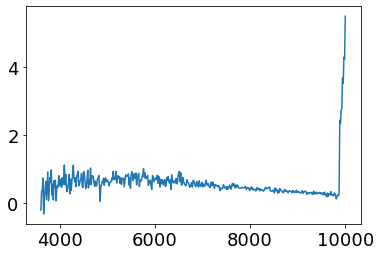

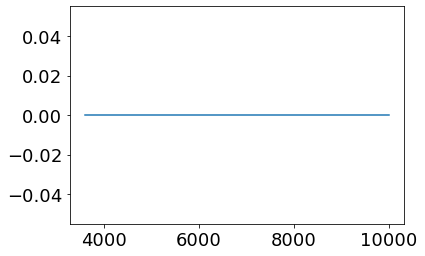

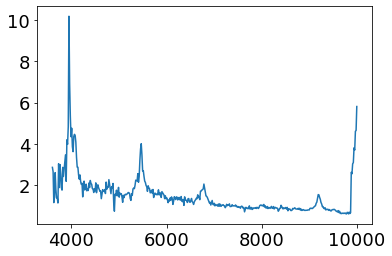

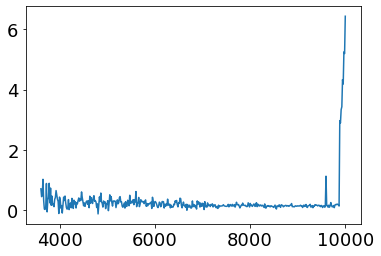

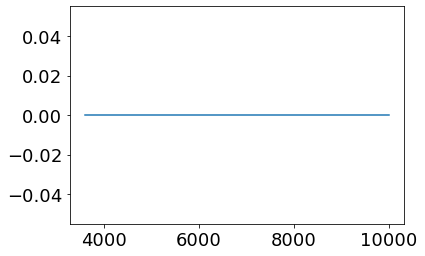

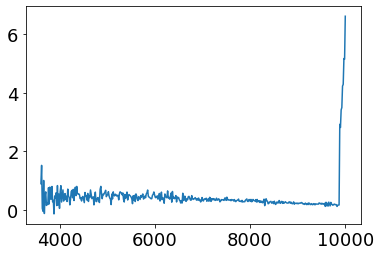

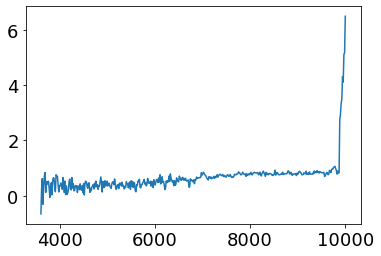

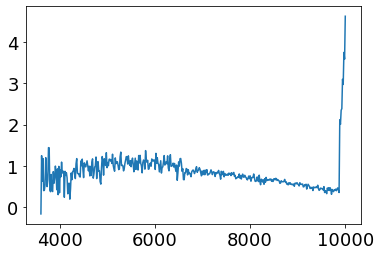

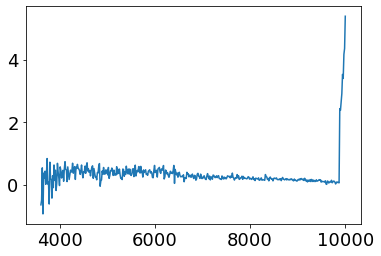

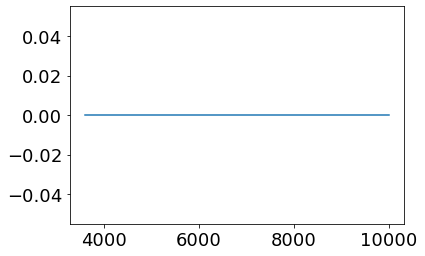

In [288]:
for num in range(10):
    plt.figure()
    k = np.linspace(3600,10000,len(file[0][num,:443][0]))
    plt.plot(k,file[0][num,:443][0])
plt.show()